In [1]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

def plot_value_function(i, j, k, values, grid):

    plt.contourf(grid.coordinate_vectors[0],
                 grid.coordinate_vectors[1],
                 values[:, :, i, j, k].T)
    plt.colorbar()
    plt.contour(grid.coordinate_vectors[0],
                grid.coordinate_vectors[1],
                values[:, :, i, j, k].T,
                levels=0,
                colors="black",
                linewidths=3)

    plt.title("angle: %.2f deg, v_rob: %.2f, v_hum: %.2f"%(grid.coordinate_vectors[2][i] * 180 / jnp.pi, grid.coordinate_vectors[3][j], grid.coordinate_vectors[4][k]))

In [2]:

import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt


import hj_reachability as hj
# from aa598.hw3_helper import plot_value_function

In [3]:
class RelativeDynamicUnicycle(hj.ControlAndDisturbanceAffineDynamics):

    def __init__(self,
                 ego_min_acceleration=-.5,
                 ego_max_acceleration=.5,
                 contender_min_acceleration=-.5,
                 contender_max_acceleration=.5,
                 ego_angular_rate_limit=.3,
                 contender_angular_rate_limit=.3,
                 ego_min_speed=0.,
                 ego_max_speed=2.,
                 contender_min_speed=0.,
                 contender_max_speed=2.,
                 control_mode="max",
                 disturbance_mode="min",
                 control_space=None,
                 disturbance_space=None):
        
        self.ego_min_max_speed = [ego_min_speed, ego_max_speed]
        self.contender_min_max_speed = [contender_min_speed, contender_max_speed]

        if control_space is None:
            control_space = hj.sets.Box(jnp.array([-ego_angular_rate_limit, ego_min_acceleration]),
                                        jnp.array([ego_angular_rate_limit, ego_max_acceleration]))
        if disturbance_space is None:
            disturbance_space = hj.sets.Box(jnp.array([-contender_angular_rate_limit, contender_min_acceleration]),
                                            jnp.array([contender_angular_rate_limit, contender_max_acceleration]))     
               
        super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)


    def open_loop_dynamics(self, state, time):
        xR, yR, thetaR, vA, vB = state
        # limit speed
        vA = jnp.clip(vA, *self.ego_min_max_speed)
        vB = jnp.clip(vB, *self.contender_min_max_speed)
        # TODO: WRITE YOUR CODE HERE
        xR_dot = vB * jnp.cos(thetaR) - vA
        yR_dot = vB * jnp.sin(thetaR)
        return jnp.array([xR_dot, yR_dot, 0, 0., 0.])
    
    def control_jacobian(self, state, time):
        # TODO: WRITE YOUR CODE HERE
        xR, yR, thetaR, vA, vB = state
        return jnp.array([
            [yR, 0.],
            [-xR, 0.],
            [-1., 0.],
            [0., 1.],
            [0., 0.],
        ])
    
    def disturbance_jacobian(self, state, time):
        # TODO: WRITE YOUR CODE HERE
        return jnp.array([
            [0., 0.],
            [0., 0.],
            [1., 0.],
            [0., 0.],
            [0., 1.],
        ])

In [4]:
# adjust the grid size as necessary depending on your available compute. 
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo=np.array([-10., -10., -np.pi, -1., -1.]),
                                                                           hi=np.array([10., 10., np.pi, 3., 3.])),
                                                               (21, 21, 10, 15, 15),
                                                               periodic_dims=2)
# initial value function
r_col = 2.
init_values = jnp.linalg.norm(grid.states[..., :2], axis=-1) - r_col

# solver settings, can change accuracy to "low", "high" or "very_high". 
# set postprocessor ro backward_reachable_tube
solver_settings = hj.SolverSettings.with_accuracy("medium", hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)

# set time horizon. negative because we are computing backward in time. If target_time > 0, then you will compute the forwrd reachable set
time = 0.
target_time = -5.0

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [74]:
# using default values for the dynamics
dynamics = RelativeDynamicUnicycle()

# solve for the BRT!
target_values = hj.step(solver_settings, dynamics, grid, time, init_values, target_time)

 15%|#4        |  0.7378/5.0 [00:04<00:21,  5.02s/sim_s]

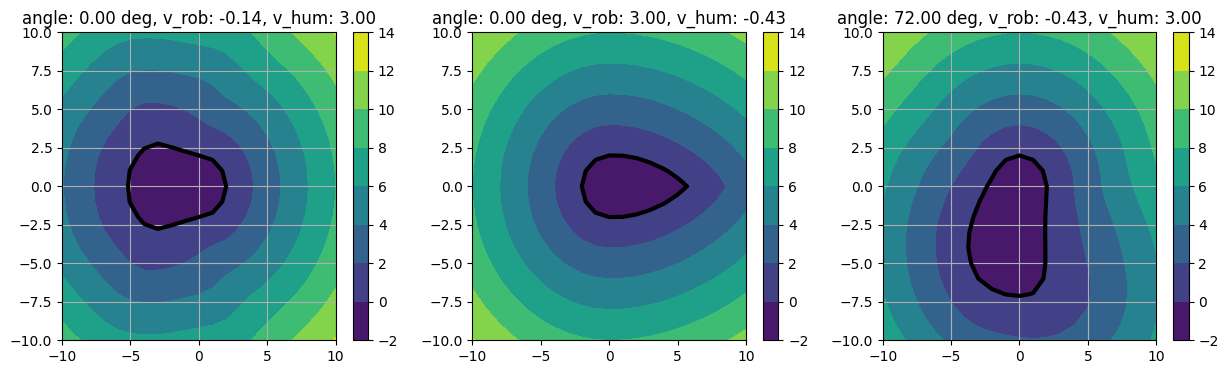

In [81]:
# plot three figures at different slices of the BRT
plt.figure(figsize=(15, 4))

plt.subplot(1,3,1)
# human faster than robot
plot_value_function(5, 3, 14, target_values, grid)
plt.grid()
plt.subplot(1,3,2)
# robot faster than human
plot_value_function(5, 14, 2, target_values, grid)
# plot_value_function(5, 5, 14, init_values, grid)


plt.subplot(1,3,3)
plt.grid()
plot_value_function(7, 2, 14, target_values, grid)

In [82]:
# TODO: set values according to your assumption on agnet behavior

# Case 1: Both agent cannot turn nor accelerate
ego_min_acceleration=0.
ego_max_acceleration=0.
contender_min_acceleration=0.
contender_max_acceleration=0.
ego_angular_rate_limit=0.
contender_angular_rate_limit=0.
ego_min_speed=0.
ego_max_speed=2.
contender_min_speed=0.
contender_max_speed=2.
control_mode="max"
disturbance_mode="min"
control_space=None
disturbance_space=None

dynamics = RelativeDynamicUnicycle(
                                    ego_min_acceleration=ego_min_acceleration,
                                    ego_max_acceleration=ego_max_acceleration,
                                    contender_min_acceleration=contender_min_acceleration,
                                    contender_max_acceleration=contender_max_acceleration,
                                    ego_angular_rate_limit=ego_angular_rate_limit,
                                    contender_angular_rate_limit=contender_angular_rate_limit,
                                    ego_min_speed=ego_min_speed,
                                    ego_max_speed=ego_max_speed,
                                    contender_min_speed=contender_min_speed,
                                    contender_max_speed=contender_max_speed,
                                    control_mode=control_mode,
                                    disturbance_mode=disturbance_mode
                                    )

target_values = hj.step(solver_settings, dynamics, grid, time, init_values, target_time)

100%|##########|  5.0000/5.0 [00:07<00:00,  1.45s/sim_s]


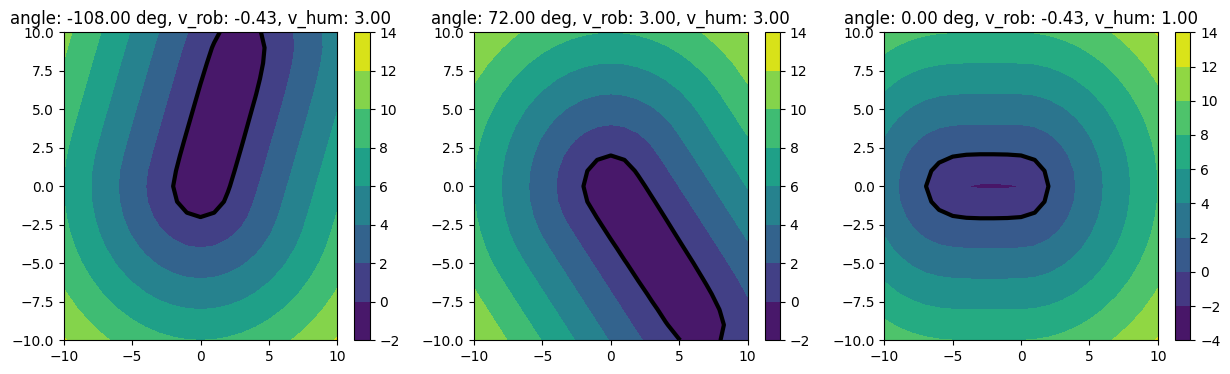

In [92]:
# plot for case 1:
plt.figure(figsize=(15, 4))

plt.subplot(1,3,1)
# human faster than robot
plot_value_function(2, 2, 14, target_values, grid)

plt.subplot(1,3,2)
# robot faster than human
plot_value_function(7, 14, 14, target_values, grid)

plt.subplot(1,3,3)

plot_value_function(5, 2, 7, target_values, grid)

In [ ]:
# case 2:  each agent will maximally brake but is free to rotate
ego_min_acceleration=-2.
ego_max_acceleration=-2.
contender_min_acceleration=-2.
contender_max_acceleration=-2.
ego_angular_rate_limit=5
contender_angular_rate_limit=5
ego_min_speed=0.
ego_max_speed=2.
contender_min_speed=0.
contender_max_speed=2.
control_mode="max"
disturbance_mode="min"
control_space=None
disturbance_space=None

dynamics = RelativeDynamicUnicycle(
                                    ego_min_acceleration=ego_min_acceleration,
                                    ego_max_acceleration=ego_max_acceleration,
                                    contender_min_acceleration=contender_min_acceleration,
                                    contender_max_acceleration=contender_max_acceleration,
                                    ego_angular_rate_limit=ego_angular_rate_limit,
                                    contender_angular_rate_limit=contender_angular_rate_limit,
                                    ego_min_speed=ego_min_speed,
                                    ego_max_speed=ego_max_speed,
                                    contender_min_speed=contender_min_speed,
                                    contender_max_speed=contender_max_speed,
                                    control_mode=control_mode,
                                    disturbance_mode=disturbance_mode
                                    )

target_values = hj.step(solver_settings, dynamics, grid, time, init_values, target_time)





100%|##########|  5.0000/5.0 [04:23<00:00, 52.68s/sim_s]


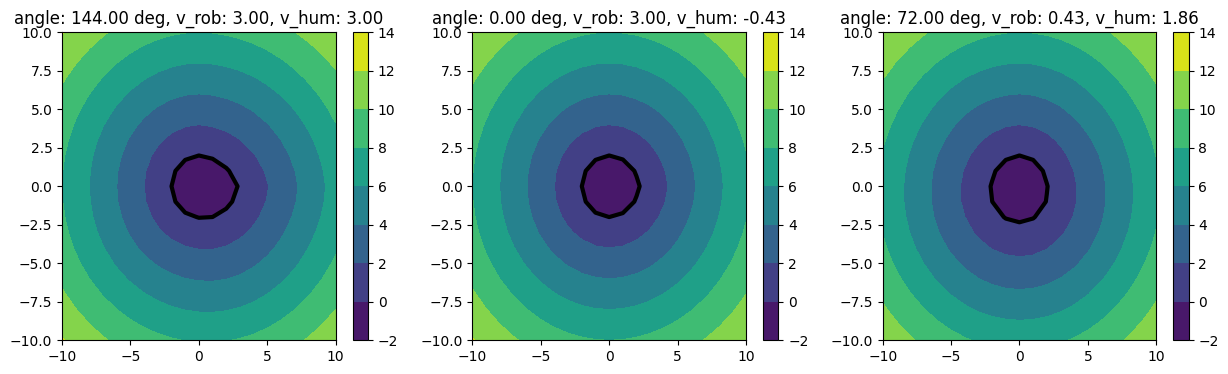

In [31]:
# plot for case2
plt.figure(figsize=(15, 4))

plt.subplot(1,3,1)
# human faster than robot
plot_value_function(9, 14, 14, target_values, grid)

plt.subplot(1,3,2)
# robot faster than human
plot_value_function(5, 14, 2, target_values, grid)

plt.subplot(1,3,3)

plot_value_function(7, 5, 10, target_values, grid)

In [ ]:
# Case3: cat-catching robot
# cat can change its direction faster than the robot, but cannot
# (de)accelerate as much as the robot
ego_min_acceleration=-0.5
ego_max_acceleration=0.5
contender_min_acceleration=-0.1
contender_max_acceleration=0.1
ego_angular_rate_limit=.3
contender_angular_rate_limit=.7
ego_min_speed=0.
ego_max_speed=2.
contender_min_speed=0.
contender_max_speed=2.
control_mode="min"
disturbance_mode="max"
control_space=None
disturbance_space=None

dynamics = RelativeDynamicUnicycle(
                                    ego_min_acceleration=ego_min_acceleration,
                                    ego_max_acceleration=ego_max_acceleration,
                                    contender_min_acceleration=contender_min_acceleration,
                                    contender_max_acceleration=contender_max_acceleration,
                                    ego_angular_rate_limit=ego_angular_rate_limit,
                                    contender_angular_rate_limit=contender_angular_rate_limit,
                                    ego_min_speed=ego_min_speed,
                                    ego_max_speed=ego_max_speed,
                                    contender_min_speed=contender_min_speed,
                                    contender_max_speed=contender_max_speed,
                                    control_mode=control_mode,
                                    disturbance_mode=disturbance_mode
                                    )

target_values = hj.step(solver_settings, dynamics, grid, time, init_values, target_time)

100%|##########|  5.0000/5.0 [00:21<00:00,  4.39s/sim_s]


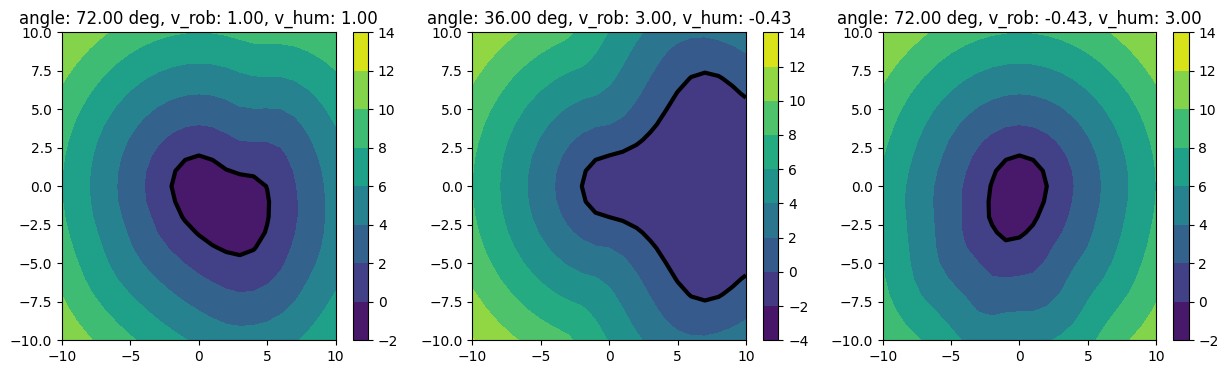

In [120]:


# plot for case3: cat-catching
plt.figure(figsize=(15, 4))

plt.subplot(1,3,1)
# human faster than robot
plot_value_function(7, 7, 7, target_values, grid)

plt.subplot(1,3,2)
# robot faster than human
plot_value_function(6, 14, 2, target_values, grid)

plt.subplot(1,3,3)

plot_value_function(7, 2, 14, target_values, grid)